In [1]:
import os
import xml.etree.ElementTree as ET
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.datasets import VisionDataset
import collections
import torchvision.transforms as T
import random
import torch

# Arguments setup (mock args to simulate the environment)
class Args:
    def __init__(self):
        self.dataset = "OWDETR"
        self.data_root = "/mnt/sdb1/hjlim/09/PROB/data/OWOD"
        self.train_set = 'owdetr_t1_train'
        self.test_set = 'owod_all_task_test'
        self.PREV_INTRODUCED_CLS = 0
        self.CUR_INTRODUCED_CLS = 20

args = Args()

In [3]:
# Helper function to extract file names
def extract_fns(image_set, voc_root):
    splits_dir = os.path.join(voc_root, 'ImageSets', args.dataset)
    split_f = os.path.join(splits_dir, image_set + '.txt')
    with open(os.path.join(split_f), "r") as f:
        file_names = [x.strip() for x in f.readlines()]
    return file_names

In [4]:
# Function to create data transforms
def make_coco_transforms(image_set):
    normalize = T.Compose([
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    scales = [480, 512, 544, 576, 608, 640, 672, 704, 736, 768, 800]
    
    if 'train' in image_set:
        t = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomApply([
                T.Resize((random.choice(scales), random.choice(scales)))
            ], p=0.5),
            normalize,
        ])
        return t
    
    if 'ft' in image_set or 'val' in image_set or 'test' in image_set:
        t = T.Compose([
            T.Resize((800, 800)),
            normalize,
        ])
        return t

    raise ValueError(f'unknown {image_set}')


In [5]:
# Initialize OWDetection Dataset
class OWDetection(VisionDataset):
    def __init__(self, args, root, image_set='train', transforms=None, dataset='OWDETR'):
        super(OWDetection, self).__init__(root, transforms=transforms)
        self.images = []
        self.annotations = []
        self.image_set = []
        self.imgids = []
        self.CLASS_NAMES = [
            "airplane", "dining table", "motorcycle", "potted plant", "couch", "tv", "unknown"
        ]
        self.args = args
        self.dataset = dataset
        self.transforms = transforms

        # Annotation and Image directory paths
        annotation_dir = os.path.join(self.root, 'Annotations')
        image_dir = os.path.join(self.root, 'JPEGImages')

        file_names = extract_fns(image_set, self.root)

        # Populating dataset with images and annotations paths
        self.image_set.extend(file_names)
        self.images.extend([os.path.join(image_dir, x + ".jpg") for x in file_names])
        self.annotations.extend([os.path.join(annotation_dir, x + ".xml") for x in file_names])
        
    def parse_voc_xml(self, node):
        voc_dict = {}
        children = list(node)
        if children:
            def_dic = collections.defaultdict(list)
            for dc in map(self.parse_voc_xml, children):
                for ind, v in dc.items():
                    def_dic[ind].append(v)
            voc_dict = {
                node.tag:
                    {ind: v[0] if len(v) == 1 else v
                     for ind, v in def_dic.items()}
            }
        if node.text:
            text = node.text.strip()
            if not children:
                voc_dict[node.tag] = text
        return voc_dict

In [6]:
args.train_set

'owdetr_t1_train'

In [7]:
# Load the dataset instance with transforms
dataset_train = OWDetection(args, args.data_root, image_set=args.train_set, transforms=make_coco_transforms(args.train_set))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


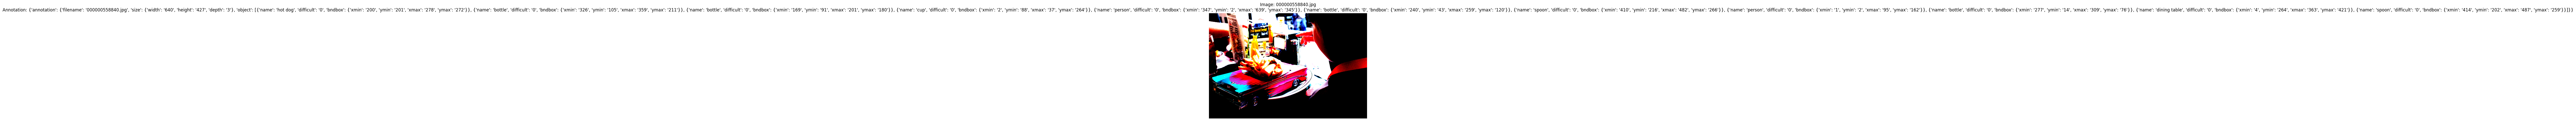

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


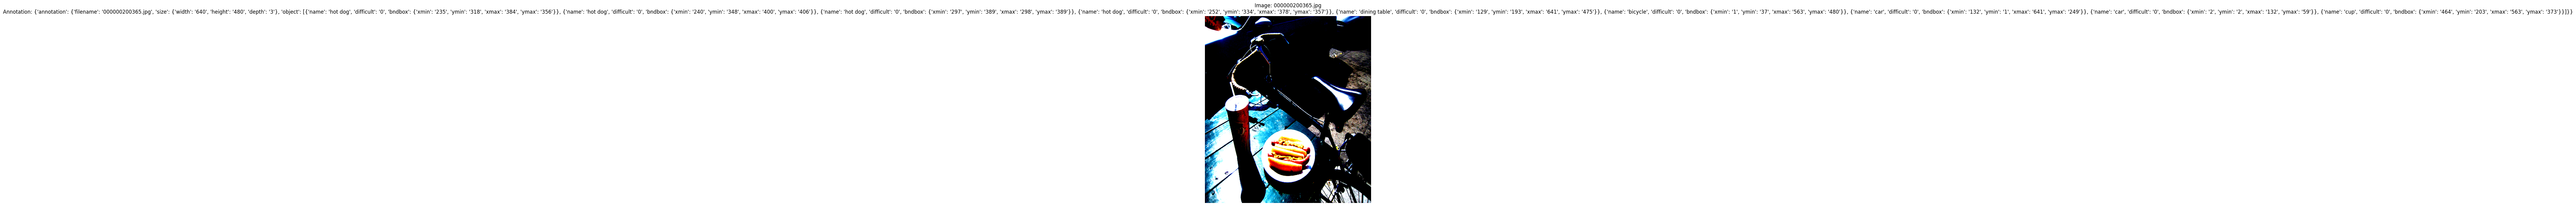

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


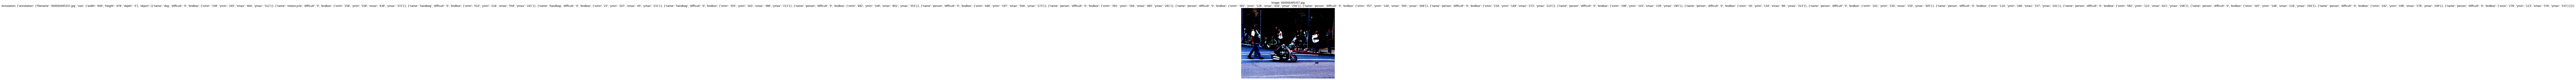

In [8]:
# Displaying some images with their annotation for better understanding
for img_path, annotation_path in zip(dataset_train.images[:3], dataset_train.annotations[:3]):
    # Loading the image
    img = Image.open(img_path).convert('RGB')
    
    # Applying transforms if available
    if dataset_train.transforms:
        img = dataset_train.transforms(img)
    
    # Loading the XML annotation file and parsing the content
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    annotation = dataset_train.parse_voc_xml(root)
    
    # Plot the image
    plt.figure(figsize=(8, 8))
    if isinstance(img, torch.Tensor):
        plt.imshow(img.permute(1, 2, 0))  # Convert tensor (C, H, W) to (H, W, C) for plotting
    else:
        plt.imshow(img)
    plt.axis('off')
    plt.title(f"Image: {os.path.basename(img_path)}\nAnnotation: {annotation}")
    plt.show()

In [28]:
import argparse
import datetime
import json
import random
import time
from pathlib import Path
import os
import numpy as np
import torch
from torch.utils.data import DataLoader
import datasets
import util.misc as utils
import datasets.samplers as samplers
from datasets import build_dataset, get_coco_api_from_dataset
from datasets.coco import make_coco_transforms
from datasets.torchvision_datasets.open_world import OWDetection
from engine import evaluate, train_one_epoch, get_exemplar_replay
from models import build_model
import wandb
import os
import numpy as np
import torch
import itertools
from PIL import Image
import xml.etree.ElementTree as ET
from torchvision.datasets import VisionDataset
import copy
import random
import collections
import wandb
import functools
import torch
import os
import numpy as np
import itertools
import xml.etree.ElementTree as ET
from PIL import Image
from torchvision.datasets import VisionDataset
import collections
import copy



In [33]:
def get_args_parser():
    parser = argparse.ArgumentParser('Deformable DETR Detector', add_help=False)
    ################ Deformable DETR ################
    parser.add_argument('--lr', default=2e-4, type=float)
    parser.add_argument('--lr_backbone_names', default=["backbone.0"], type=str, nargs='+')
    parser.add_argument('--lr_backbone', default=2e-5, type=float)
    parser.add_argument('--lr_linear_proj_names', default=['reference_points', 'sampling_offsets'], type=str, nargs='+')
    parser.add_argument('--lr_linear_proj_mult', default=0.1, type=float)
    parser.add_argument('--batch_size', default=1, type=int)
    parser.add_argument('--weight_decay', default=1e-4, type=float)
    parser.add_argument('--epochs', default=1, type=int)
    parser.add_argument('--lr_drop', default=35, type=int)
    parser.add_argument('--lr_drop_epochs', default=None, type=int, nargs='+')
    parser.add_argument('--clip_max_norm', default=0.1, type=float,
                        help='gradient clipping max norm')
    parser.add_argument('--sgd', action='store_true')
    # Variants of Deformable DETR
    parser.add_argument('--with_box_refine', default=False, action='store_true')
    parser.add_argument('--two_stage', default=False, action='store_true')
    parser.add_argument('--masks', default=False, action='store_true', help="Train segmentation head if the flag is provided")
    parser.add_argument('--backbone', default='dino_resnet50', type=str, help="Name of the convolutional backbone to use")

    # Model parameters
    parser.add_argument('--frozen_weights', type=str, default=None,
                        help="Path to the pretrained model. If set, only the mask head will be trained")
    parser.add_argument('--dilation', action='store_true',
                        help="If true, we replace stride with dilation in the last convolutional block (DC5)")
    parser.add_argument('--position_embedding', default='sine', type=str, choices=('sine', 'learned'),
                        help="Type of positional embedding to use on top of the image features")
    parser.add_argument('--position_embedding_scale', default=2 * np.pi, type=float,
                        help="position / size * scale")
    parser.add_argument('--num_feature_levels', default=4, type=int, help='number of feature levels')

    # * Transformer
    parser.add_argument('--enc_layers', default=6, type=int,
                        help="Number of encoding layers in the transformer")
    parser.add_argument('--dec_layers', default=6, type=int,
                        help="Number of decoding layers in the transformer")
    parser.add_argument('--dim_feedforward', default=1024, type=int,
                        help="Intermediate size of the feedforward layers in the transformer blocks")
    parser.add_argument('--hidden_dim', default=256, type=int,
                        help="Size of the embeddings (dimension of the transformer)")
    parser.add_argument('--dropout', default=0.1, type=float,
                        help="Dropout applied in the transformer")
    parser.add_argument('--nheads', default=8, type=int,
                        help="Number of attention heads inside the transformer's attentions")
    parser.add_argument('--num_queries', default=100, type=int,
                        help="Number of query slots")
    parser.add_argument('--dec_n_points', default=4, type=int)
    parser.add_argument('--enc_n_points', default=4, type=int)

    # Loss
    parser.add_argument('--no_aux_loss', dest='aux_loss', action='store_false',
                        help="Disables auxiliary decoding losses (loss at each layer)")
    # * Matcher
    parser.add_argument('--set_cost_class', default=2, type=float,
                        help="Class coefficient in the matching cost")
    parser.add_argument('--set_cost_bbox', default=5, type=float,
                        help="L1 box coefficient in the matching cost")
    parser.add_argument('--set_cost_giou', default=2, type=float,
                        help="giou box coefficient in the matching cost")
    # Loss coefficients
    parser.add_argument('--cls_loss_coef', default=2, type=float)
    parser.add_argument('--bbox_loss_coef', default=5, type=float)
    parser.add_argument('--giou_loss_coef', default=2, type=float)
    parser.add_argument('--focal_alpha', default=0.25, type=float)
    
    # dataset parameters
    parser.add_argument('--coco_panoptic_path', type=str)
    parser.add_argument('--remove_difficult', action='store_true')
    parser.add_argument('--output_dir', default='',
                        help='path where to save, empty for no saving')
    parser.add_argument('--device', default='cuda',
                        help='device to use for training / testing')
    parser.add_argument('--seed', default=42, type=int)
    parser.add_argument('--resume', default='', help='resume from checkpoint')
    parser.add_argument('--start_epoch', default=0, type=int, metavar='N',
                        help='start epoch')
    parser.add_argument('--eval', action='store_true')
    parser.add_argument('--viz', action='store_true')
    parser.add_argument('--eval_every', default=5, type=int)
    parser.add_argument('--num_workers', default=3, type=int)
    parser.add_argument('--cache_mode', default=False, action='store_true', help='whether to cache images on memory')
    
    ################ OW-DETR ################
    parser.add_argument('--PREV_INTRODUCED_CLS', default=0, type=int)
    parser.add_argument('--CUR_INTRODUCED_CLS', default=20, type=int)
    parser.add_argument('--unmatched_boxes', default=False, action='store_true')
    parser.add_argument('--top_unk', default=5, type=int)
    parser.add_argument('--featdim', default=1024, type=int)
    parser.add_argument('--invalid_cls_logits', default=False, action='store_true', help='owod setting')
    parser.add_argument('--NC_branch', default=False, action='store_true')
    parser.add_argument('--bbox_thresh', default=0.3, type=float)
    parser.add_argument('--pretrain', default='', help='initialized from the pre-training model')
    parser.add_argument('--nc_loss_coef', default=2, type=float)
    parser.add_argument('--train_set', default='', help='training txt files')
    parser.add_argument('--test_set', default='', help='testing txt files')
    parser.add_argument('--num_classes', default=81, type=int)
    parser.add_argument('--nc_epoch', default=0, type=int)
    parser.add_argument('--dataset', default='OWDETR', help='defines which dataset is used. Built for: {TOWOD, OWDETR, VOC2007}')
    parser.add_argument('--data_root', default='/mnt/sdb1/hjlim/09/PROB/data/OWOD', type=str)
    parser.add_argument('--unk_conf_w', default=1.0, type=float)

    ################ PROB OWOD ################
    # model config
    parser.add_argument('--model_type', default='prob', type=str)
    
    # logging
    parser.add_argument('--wandb_name', default='PROB_V1', type=str)
    parser.add_argument('--wandb_project', default='PROB_V1', type=str)  # 프로젝트 이름 변경
    
    # model hyperparameters
    parser.add_argument('--obj_loss_coef', default=1, type=float)
    parser.add_argument('--obj_temp', default=1, type=float)
    parser.add_argument('--freeze_prob_model', default=False, action='store_true', help='freeze model probabistic estimation')

    
    # Exemplar replay selection
    parser.add_argument('--num_inst_per_class', default=50, type=int, help="number of instances per class")
    parser.add_argument('--exemplar_replay_selection', default=False, action='store_true', help='use learned exemplar selection')
    parser.add_argument('--exemplar_replay_max_length', default=1e10, type=int, help="max number of images that can be saves")
    parser.add_argument('--exemplar_replay_dir', default='', type=str, help="directory of exemplar replay txt files")
    parser.add_argument('--exemplar_replay_prev_file', default='', type=str, help="path to previous ft file")
    parser.add_argument('--exemplar_replay_cur_file', default='', type=str, help="path to current ft file")
    parser.add_argument('--exemplar_replay_random', default=False, action='store_true', help='make selection random')
    return parser

In [34]:
parser = get_args_parser()
args = parser.parse_args([])

# 필요한 파라미터를 직접 설정
args.lr = 2e-4
args.lr_backbone = 2e-5
args.batch_size = 2
args.epochs = 5
args.output_dir = 'output_directory'
args.dataset = 'OWDETR'
args.train_set = 'owod_t1_train'
args.test_set = 'owod_t1_test'
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.wandb_project = 'PROB_V1'
args.wandb_name = 'PROB_V1'

In [35]:
# VOC 데이터셋 클래스 목록 정의
VOC_CLASS_NAMES_COCOFIED = [
    "airplane", "dining table", "motorcycle",
    "potted plant", "couch", "tv"
]

BASE_VOC_CLASS_NAMES = [
    "aeroplane", "diningtable", "motorbike",
    "pottedplant", "sofa", "tvmonitor"
]

UNK_CLASS = ["unknown"]

# OWOD에서 사용하는 클래스
T1_CLASS_NAMES = [
    "aeroplane", "bicycle", "bird", "boat", "bus", "car",
    "cat", "cow", "dog", "horse", "motorbike", "sheep", "train",
    "elephant", "bear", "zebra", "giraffe", "truck", "person"
]

In [36]:
# 모든 클래스 출력
VOC_COCO_CLASS_NAMES = {}
VOC_COCO_CLASS_NAMES["OWDETR"] = tuple(itertools.chain(T1_CLASS_NAMES, UNK_CLASS))
print("VOC_COCO_CLASS_NAMES:", VOC_COCO_CLASS_NAMES)

VOC_COCO_CLASS_NAMES: {'OWDETR': ('aeroplane', 'bicycle', 'bird', 'boat', 'bus', 'car', 'cat', 'cow', 'dog', 'horse', 'motorbike', 'sheep', 'train', 'elephant', 'bear', 'zebra', 'giraffe', 'truck', 'person', 'unknown')}


In [37]:
class OWDetection(VisionDataset):
    def __init__(self,
                 args,
                 root,
                 image_set='train',
                 transforms=None,
                 filter_pct=-1,
                 dataset='OWDETR'):
        super(OWDetection, self).__init__(transforms)
        self.images = []
        self.annotations = []
        self.imgids = []
        self.imgid2annotations = {}
        self.image_set = []
        self.transforms = transforms
        self.CLASS_NAMES = VOC_COCO_CLASS_NAMES[dataset]
        self.args = args
        self.dataset = dataset

        self.root = str(root)
        annotation_dir = os.path.join(self.root, 'Annotations')
        image_dir = os.path.join(self.root, 'JPEGImages')

        file_names = self.extract_fns(image_set, self.root)
        print(image_set)

        # File parsing logic, making sure paths exist in the environment
        if image_set == 'voc2007_trainval':
            # Specific logic for 'voc2007_trainval'
            pass
        else:
            self.image_set.extend(file_names)
            self.images.extend([os.path.join(image_dir, x + ".jpg") for x in file_names])
            self.annotations.extend([os.path.join(annotation_dir, x + ".xml") for x in file_names])
            self.imgids.extend(self.convert_image_id(x, to_integer=True) for x in file_names)
        
        # More initialization code...
    
    def extract_fns(self, image_set, voc_root):
        splits_dir = os.path.join(voc_root, 'ImageSets', self.dataset)
        split_f = os.path.join(splits_dir, image_set + '.txt')
        if not os.path.exists(split_f):
            print(f"Warning: The file {split_f} does not exist.")
            return []

        with open(os.path.join(split_f), "r") as f:
            file_names = [x.strip() for x in f.readlines()]
        return file_names

    # Other methods like `load_instances`, `convert_image_id`, etc., are similarly copied over.
    @staticmethod
    def convert_image_id(img_id, to_integer=False, to_string=False, prefix='2021'):
        if to_integer:
            return int(prefix + img_id.replace('_', ''))
        if to_string:
            x = str(img_id)
            assert x.startswith(prefix)
            x = x[len(prefix):]
            if len(x) == 12 or len(x) == 6:
                return x
            return x[:4] + '_' + x[4:]

    @functools.lru_cache(maxsize=None)
    def load_instances(self, img_id):
        tree = ET.parse(self.imgid2annotations[img_id])
        target = self.parse_voc_xml(tree.getroot())
        image_id = target['annotation']['filename']
        instances = []
        for obj in target['annotation']['object']:
            cls = obj["name"]

            if cls in VOC_CLASS_NAMES_COCOFIED:
                cls = BASE_VOC_CLASS_NAMES[VOC_CLASS_NAMES_COCOFIED.index(cls)]
            bbox = obj["bndbox"]
            bbox = [float(bbox[x]) for x in ["xmin", "ymin", "xmax", "ymax"]]
            bbox[0] -= 1.0
            bbox[1] -= 1.0
            instance = dict(
                category_id=self.CLASS_NAMES.index(cls),
                bbox=bbox,
                area=(bbox[2] - bbox[0]) * (bbox[3] - bbox[1]),
                image_id=img_id
            )
            instances.append(instance)
        return target, instances

    def extract_fns(self, image_set, voc_root):
        # import ipdb; ipdb.set_trace()
        splits_dir = os.path.join(voc_root, 'ImageSets')
        splits_dir = os.path.join(splits_dir, self.dataset)
        print(splits_dir)
        # import ipdb; ipdb.set_trace()

        split_f = os.path.join(splits_dir, image_set.rstrip('\n') + '.txt')
        with open(os.path.join(split_f), "r") as f:
            file_names = [x.strip() for x in f.readlines()]
        return file_names

    ### OWOD
    def remove_prev_class_and_unk_instances(self, target):
        # For training data. Removing earlier seen class objects and the unknown objects..
        prev_intro_cls = self.args.PREV_INTRODUCED_CLS
        curr_intro_cls = self.args.CUR_INTRODUCED_CLS
        valid_classes = range(prev_intro_cls, prev_intro_cls + curr_intro_cls)
        entry = copy.copy(target)
        for annotation in copy.copy(entry):
            if annotation["category_id"] not in valid_classes:
                entry.remove(annotation)
        return entry

    def remove_unknown_instances(self, target):
        # For finetune data. Removing the unknown objects...
        prev_intro_cls = self.args.PREV_INTRODUCED_CLS
        curr_intro_cls = self.args.CUR_INTRODUCED_CLS
        valid_classes = range(0, prev_intro_cls+curr_intro_cls)
        entry = copy.copy(target)
        for annotation in copy.copy(entry):
            if annotation["category_id"] not in valid_classes:
                entry.remove(annotation)
        return entry

    def label_known_class_and_unknown(self, target):
        # For test and validation data.
        # Label known instances the corresponding label and unknown instances as unknown.
        prev_intro_cls = self.args.PREV_INTRODUCED_CLS
        curr_intro_cls = self.args.CUR_INTRODUCED_CLS
        total_num_class = self.args.num_classes #81
        known_classes = range(0, prev_intro_cls+curr_intro_cls)
        entry = copy.copy(target)
        for annotation in  copy.copy(entry):
        # for annotation in entry:
            if annotation["category_id"] not in known_classes:
                annotation["category_id"] = total_num_class - 1
        return entry

    def __getitem__(self, index):
        """
        Args:
            index (int): Indexin

        Returns:
            tuple: (image, target) where target is a dictionary of the XML tree.
        """

        image_set = self.transforms[0]
        img = Image.open(self.images[index]).convert('RGB')
        target, instances = self.load_instances(self.imgids[index])
        if 'train' in image_set:
            instances = self.remove_prev_class_and_unk_instances(instances)
        elif 'test' in image_set:
            instances = self.label_known_class_and_unknown(instances)
        elif 'ft' in image_set:
            instances = self.remove_unknown_instances(instances)

        w, h = map(target['annotation']['size'].get, ['width', 'height'])
        target = dict(
            image_id=torch.tensor([self.imgids[index]], dtype=torch.int64),
            org_image_id=torch.Tensor([ord(c) for c in self.annotations[index].split('/')[-1].split('.xml')[0]]),
            labels=torch.tensor([i['category_id'] for i in instances], dtype=torch.int64),
            area=torch.tensor([i['area'] for i in instances], dtype=torch.float32),
            boxes=torch.as_tensor([i['bbox'] for i in instances], dtype=torch.float32),
            orig_size=torch.as_tensor([int(h), int(w)]),
            size=torch.as_tensor([int(h), int(w)]),
            iscrowd=torch.zeros(len(instances), dtype=torch.uint8)
        )
        #import ipdb;ipdb.set_trace()

        if self.transforms[-1] is not None:
            img, target = self.transforms[-1](img, target)

        return img, target

    def __len__(self):
        return len(self.images)

    def parse_voc_xml(self, node):
        voc_dict = {}
        children = list(node)
        if children:
            def_dic = collections.defaultdict(list)
            for dc in map(self.parse_voc_xml, children):
                for ind, v in dc.items():
                    def_dic[ind].append(v)
            if node.tag == 'annotation':
                def_dic['object'] = [def_dic['object']]
            voc_dict = {
                node.tag:
                    {ind: v[0] if len(v) == 1 else v
                     for ind, v in def_dic.items()}
            }
        if node.text:
            text = node.text.strip()
            if not children:
                voc_dict[node.tag] = text
        return voc_dict



In [38]:
import torch
import numpy as np
import random
import os
import argparse
from datasets.torchvision_datasets.open_world import OWDetection
from datasets.coco import make_coco_transforms

# make_coco_transforms 함수로 train 및 validation 세트 생성
transforms_train = make_coco_transforms(args.train_set)
transforms_val = make_coco_transforms(args.test_set)

In [39]:
# 데이터셋 생성 및 출력
train_set = args.train_set
test_set = args.test_set
dataset_train = OWDetection(args, args.data_root, image_set=args.train_set, transforms=transforms_train, dataset=args.dataset)
dataset_val = OWDetection(args, args.data_root, image_set=args.test_set, dataset=args.dataset, transforms=transforms_val)

/mnt/sdb1/hjlim/09/PROB/data/OWOD/ImageSets/OWDETR


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/sdb1/hjlim/09/PROB/data/OWOD/ImageSets/OWDETR/owod_t1_train.txt'